# This is a test code for plotting the inter area connectivity results


In [8]:
import os
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import sys
sys.path.insert(0, '/Users/elhamb/Documents/Codes/Git/MouseVisualCoding/MouseVisCode')
sys.path.insert(0,'/Users/elhamb/Documents/Codes/Git/MouseVisualCoding/External/pydynet')
from dynet_con import dynet_connplot

import pdc_functions as PDCF
import _pickle as cPickle
import numpy as np
from itertools import compress
import tensorly.decomposition as tldecom
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.decomposition as skldecomp


## Load the previousley computed iPDC matrices

In order to load the iPDC matrices you either select the file with their names, or you provide the analysis parameter that was used before

In [2]:
ResultPath = '/Volumes/Elham-Unifr/Data/AllenBrainAll/Results/AverageResults'  # where to save the results

# parameters for preprocessing
cond_name = 'drifting_gratings'  # condition for iPDC analysis
down_sample_rate = 5  # down-sampling rate-> orginal data is 1250
pre_stim = 1  # prestimulus time window, in seconds
preproc_dict_BO = { # which preprocessing to use for PDC analysis
    'cond_name': cond_name,
    'srate': down_sample_rate,
    'prestim': pre_stim
}

# parameters for iPDC analsis
ROI_list = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']  # ROIs to include
Mord = 15  # Model order
ff = .98  # Filtering factor
pdc_method = 'iPDC'  # Method for connectivity estimation
# a list of dictionaries, each element of list indicate the parameters to consider on conditions for FC analysis,
# Note: put the values of dict as list of params
stim_params = [{'contrast': [.8], 'temporal_frequency':[2.0]}]

PDCparam_dict = {
    'ROI_list': ROI_list,
    'Mord': Mord,
    'ff': ff,
    'pdc_method': pdc_method,
    'stim_param': stim_params
}

In [3]:
filename = PDCF.search_PDC("FullData_ROI", ResultPath, PDCparam_dict, preproc_dict_BO) # full data

#load the average file:
file = open(filename, "rb")
dataPickle = file.read()
file.close()
Arg_dict = cPickle.loads(dataPickle)

In [4]:
animal_set = 766640955
dims = Arg_dict['PDCs'][animal_set]['PDC_ROI']['VISp'].shape
rois = list(Arg_dict['PDCs'][animal_set]['PDC_ROI'].keys())

First estimate the correlation between every two ROIs

In [5]:
roi_corr = np.zeros([len(rois),len(rois),dims[2],dims[3]])
Ind = np.setdiff1d(np.array(range(0,36)),np.array(range(0,36,7))) # indices of the connections

for roi1 in rois:
    print(roi1)
    for roi2 in rois:
        x = Arg_dict['PDCs'][animal_set]['PDC_ROI'][roi1]
        y = Arg_dict['PDCs'][animal_set]['PDC_ROI'][roi2]
        
        x = x.data.reshape(dims[0]*dims[1],dims[2],dims[3])
        y = y.data.reshape(dims[0]*dims[1],dims[2],dims[3])
        
        x = x[Ind,:,:]
        y = y[Ind,:,:]
        T = [[np.corrcoef(x[:,i,j],y[:,i,j])[0,1] for i in range(0,dims[2])] for j in range(0,dims[3])]
        
        roi_corr[rois.index(roi1),rois.index(roi2),:,:] = np.array(T).transpose()


VISp


//anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


VISl
VISrl
VISal
VISam


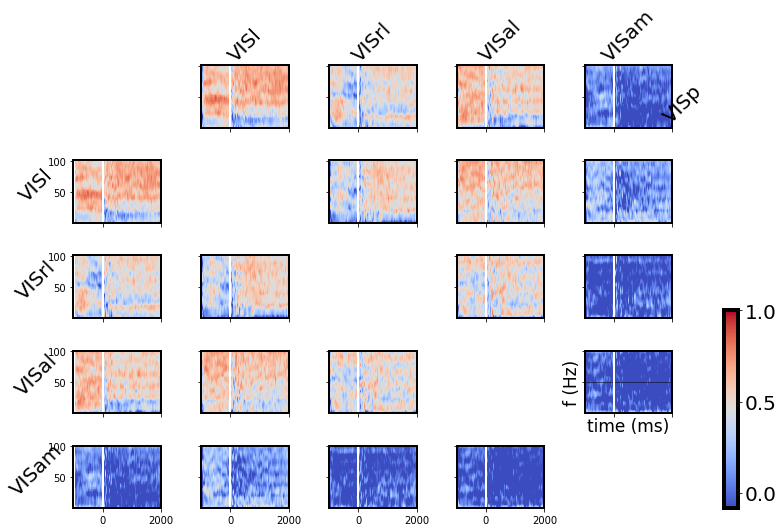

In [7]:
dynet_connplot(roi_corr,Arg_dict['PDCs'][animal_set]['PDC_ROI'][roi1].time.values,
               Arg_dict['PDCs'][animal_set]['PDC_ROI'][roi1].freq.values,
               labels=rois,quantrange=[0.1, 0.9],
               cmap = 'coolwarm',SC = None,univ = 0)


In [229]:
np.nanmin(roi_corr)<0

True

## PARAFAC Analysis

In [67]:
figure_folder = filename.split('.pkl')[0]
animal_set = 766640955
PARAFAC = {}
ttime = {}
ncomp = 3
for roi in Arg_dict['PDCs'][animal_set]['ROIs']:
    print(roi)
    temp = Arg_dict['PDCs'][animal_set]['PDC_ROI'][roi]

    dims = temp.data.shape
    
    ttime[roi] = temp.time.values[100:550]

    temp2 = temp.data.reshape(dims[0]*dims[1],dims[2],dims[3])

    Ind = np.setdiff1d(np.array(range(0,36)),np.array(range(0,36,7)));#
    
    PARAFAC[roi] = tldecom.non_negative_parafac(temp2[Ind,:,100:550], rank=ncomp)
    temp_decomp = temp2[Ind,:,100:550]


VISp
VISl
VISrl
VISal
VISam


array([0.54640843, 0.63007247, 0.66718564, 0.70007722, 0.72830625,
       0.7537535 , 0.77543542, 0.7950761 , 0.81322545, 0.82991938,
       0.84436933, 0.85803294, 0.87119672, 0.88334623, 0.89465092,
       0.90540234, 0.91573659, 0.92564042, 0.9344825 , 0.94260901])

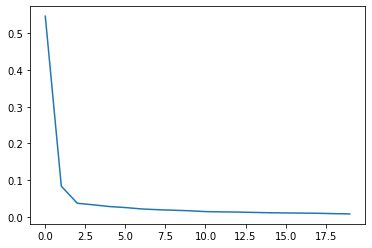

In [158]:
temp_decomp = temp2[Ind,:,100:550]
dims = temp_decomp.shape
temp_decomp = temp_decomp.reshape([dims[0],dims[1]*dims[2]], order='F')
pca = skldecomp.PCA(n_components=20)
pca.fit(temp_decomp.transpose())
plt.plot(pca.explained_variance_ratio_)
#plt.plot(pca.singular_values_)
#plt.plot(pca.components_[:3,:].transpose())
np.cumsum(pca.explained_variance_ratio_)

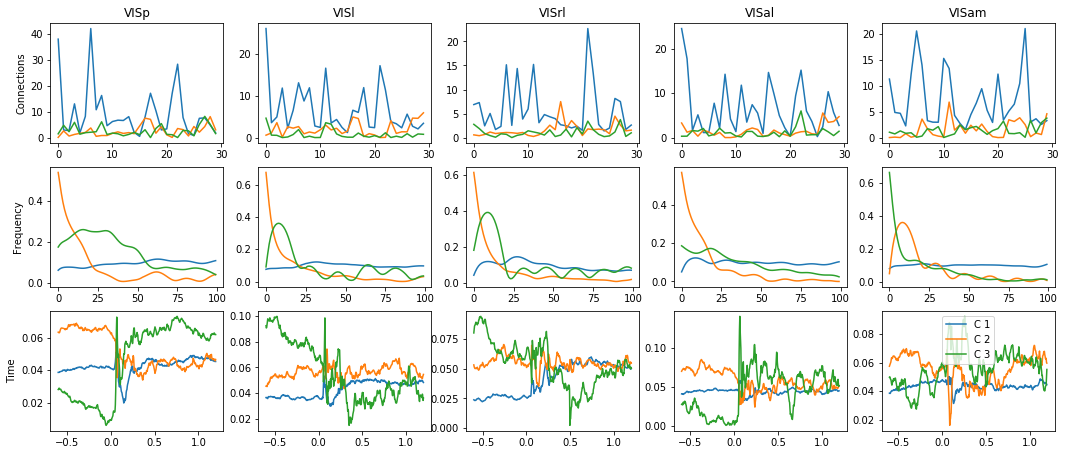

In [147]:
nroi =  len(Arg_dict['PDCs'][animal_set]['ROIs'])
dims = len(PARAFAC['VISp'].factors)
modes_names = ['Connections','Frequency','Time']
labels_comp = ['C {}'.format(x) for x in range(1,ncomp+1)]
fig, axs = plt.subplots(nrows = 3, ncols = nroi, figsize = (6*3,1.5*nroi))

for roi in range(0,nroi):
    roi_name = Arg_dict['PDCs'][animal_set]['ROIs'][roi]
    for dim in range(0,dims):
        #conn = np.zeros(dims[0],dims[1],NComp)
        if dim==2:
            axs[dim,roi].plot(ttime[roi_name],PARAFAC[roi_name].factors[dim][:,:],label='None')
        else:
            axs[dim,roi].plot(PARAFAC[roi_name].factors[dim][:,:])
            
        if dim==0:
            axs[dim,roi].set_title(roi_name)
            
        if roi==0:
            axs[dim,roi].set_ylabel(modes_names[dim])
            
        if (roi==nroi-1) & (dim==dims-1):
            handles, labels = axs[dim,roi].get_legend_handles_labels()
            axs[dim,roi].legend(handles,labels_comp)

Here we develope a similarity metric and plot the similarity matrix: 3 x 6 components

In [73]:
from sklearn.metrics import pairwise as skpw

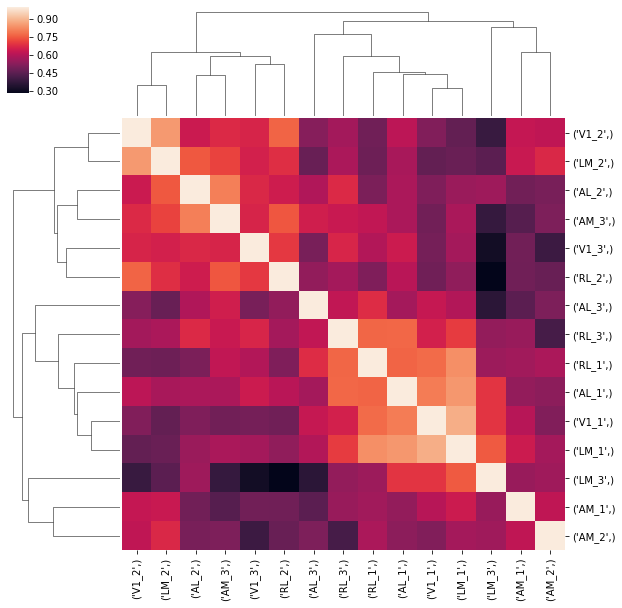

In [126]:
Load_all = np.concatenate([PARAFAC[roi].factors[0] for roi in PARAFAC.keys()],axis=1)

A = skpw.cosine_similarity(Load_all.transpose())

import seaborn as sns
ROI_names = ['V1','LM','RL','AL','AM']
labels = np.array([['{}_{}'.format(x,cmp) for cmp in range(1,ncomp+1)] for x in ROI_names]).reshape(ncomp*len(ROI_names),1)
A_pd = pd.DataFrame(A,index = labels, columns=labels)

sns.clustermap(A_pd)

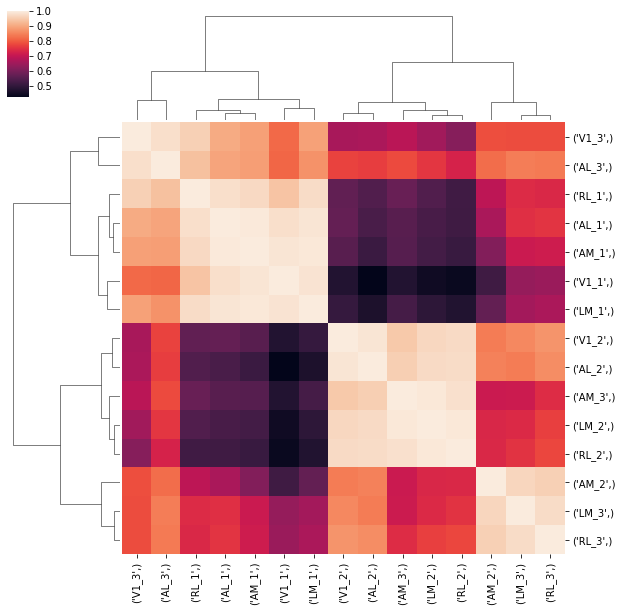

In [125]:
Load_all = np.concatenate([PARAFAC[roi].factors[1] for roi in PARAFAC.keys()],axis=1)

A = skpw.cosine_similarity(Load_all.transpose())
#A = skpw.cosine_distances(Load_all.transpose())

import seaborn as sns
ROI_names = ['V1','LM','RL','AL','AM']
labels = np.array([['{}_{}'.format(x,cmp) for cmp in range(1,ncomp+1)] for x in ROI_names]).reshape(ncomp*len(ROI_names),1)

A_pd = pd.DataFrame(A,index = labels, columns=labels)
sns.clustermap(A_pd)

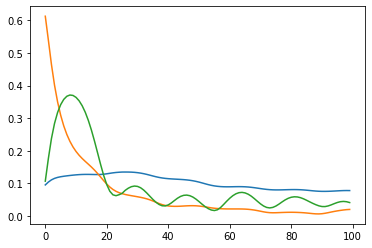

In [113]:
plt.plot(Load_all[:,[2,11,6,9,12,0,3]].mean(axis=1))

plt.plot(Load_all[:,[1,10,14,4,7]].mean(axis=1))

plt.plot(Load_all[:,[13,5,8]].mean(axis=1))

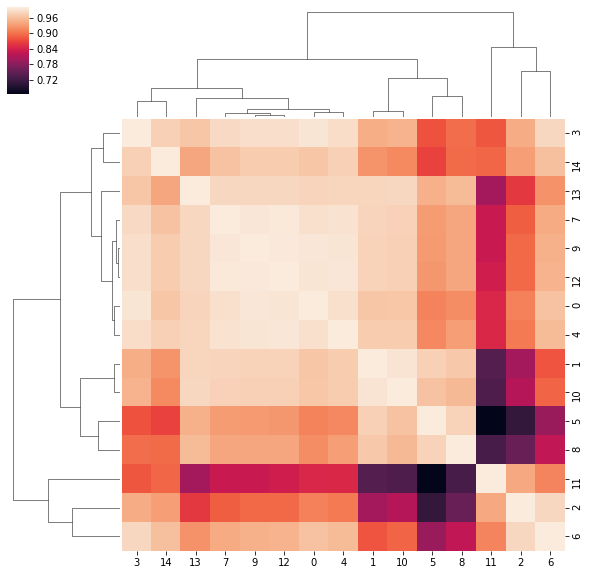

In [104]:
Load_all = np.concatenate([PARAFAC[roi].factors[2] for roi in PARAFAC.keys()],axis=1)

A = skpw.cosine_similarity(Load_all.transpose())

import seaborn as sns

sns.clustermap(A)